# Project: Scrape Images from Unsplash

## Requirements
- INPUT: keyword and number of results
- OUTPUT: highest quality images, exclude watermarked 

Try both HTML based and API based approach. Need to handle pagination (Load more) IF doing it via API side. 

### Basic exploration of the website
- We have a div with attribute data-test = search-route
- Images start in div with attribute data-test = search-photos-route
- Within that we have to find all the "figure" tags, even if they might not be direct descendants
- Then there are a few auto-generated <i>div</i> tags. 
- Finally, we hit an <i>a</i> tag which contains the href that we need
- The href will re-direct us to a new page with the full image. 
- Within div with attribute data-test = photos-route, we go down a few descendants and hit an img tag 

In [2]:
# Get script inputs

base_url = "https://unsplash.com/s/photos/"
keyword = "coffee"
main_url = base_url + keyword
num_results = 10

In [ ]:
%pip install selectolax==0.3.12

'<!doctype html>\n<html lang="en-US"><head><title data-rh="true">Coffee Pictures | Download Free Images on Unsplash</title><link data-rh="true" rel="apple-touch-icon" sizes="180x180" href="https://unsplash.com/apple-touch-icon.png"/><link data-rh="true" rel="icon" type="image/png" sizes="32x32" href="https://unsplash.com/favicon-32x32.png"/><link data-rh="true" rel="icon" type="image/png" sizes="16x16" href="https://unsplash.com/favicon-16x16.png"/><link data-rh="true" rel="mask-icon" href="https://unsplash.com/safari-pinned-tab.svg" color="#000000"/><link data-rh="true" rel="manifest" href="/site-v2.webmanifest"/><meta data-rh="true" name="charset" content="UTF8"/><meta data-rh="true" name="viewport" content="width=device-width, initial-scale=1.0, minimal-ui"/><meta data-rh="true" name="mobile-web-app-capable" content="yes"/><meta data-rh="true" name="apple-mobile-web-app-capable" content="yes"/><meta data-rh="true" name="apple-mobile-web-app-title" content="Unsplash"/><meta data-rh="
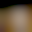
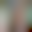
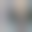
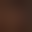
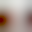
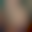
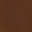
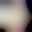
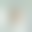
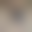
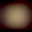
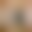
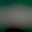
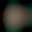
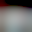
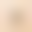
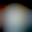
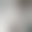
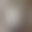
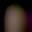
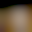
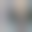
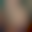
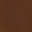
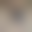
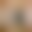
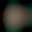
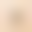
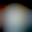
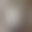
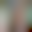
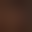
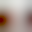
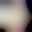
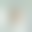
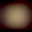
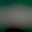
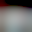
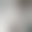
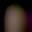
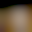
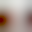
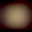
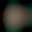
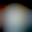
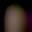
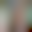
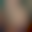
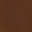
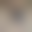
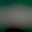
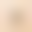
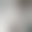
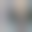
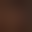
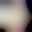
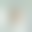
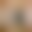
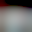
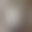
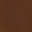
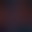
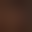
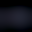
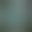
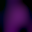
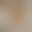
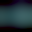
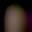
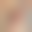
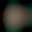
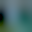
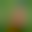
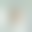
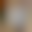
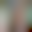
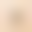
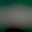
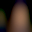
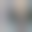
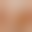
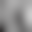
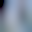
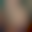
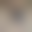
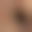
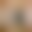
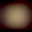
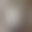
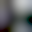
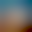
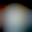
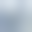
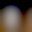
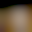
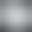
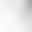
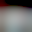
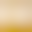
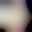
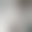
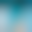
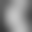
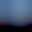
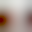
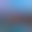
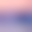
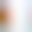
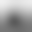
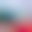

In [4]:
import requests as r

resp = r.get(main_url)
resp.text

In [24]:
# ===========================================
# HTML Scraping using Selectolax
# ===========================================

from selectolax.parser import HTMLParser
from itertools import islice

tree = HTMLParser(resp.text)
type(tree)
div1 = tree.css("div[data-test=search-photos-route] a[itemprop=contentUrl]")

# Initialize list of anchor tags with image urls
a_list = []

for a in islice(div1, num_results):
    a_list.append(a)

# We now have a list of selectolax.parser.Nodes


In [29]:
# Convert selectolax nodes to urls
img_urls = []
for a in a_list:
    url_str = "https://unsplash.com" + a.attrs["href"]
    img_urls.append(url_str)


In [37]:
# Getting the single page img src and filtering out premium images

filtered_urls = []

def get_single_img(url):
    resp2 = r.get(url)
    tree2 = HTMLParser(resp2.text)
    imgtag = tree2.css("img[srcset]")
    return imgtag[1].attrs["src"]

def premium_filter(url):
    if "premium" not in url:
        filtered_urls.append(url)

for url in img_urls:
    premium_filter(get_single_img(url))

print(filtered_urls)


['https://images.unsplash.com/photo-1509042239860-f550ce710b93?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1000&q=80', 'https://images.unsplash.com/photo-1511920170033-f8396924c348?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1000&q=80', 'https://images.unsplash.com/photo-1447933601403-0c6688de566e?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1000&q=80', 'https://images.unsplash.com/photo-1518057111178-44a106bad636?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1000&q=80', 'https://images.unsplash.com/photo-1495474472287-4d71bcdd2085?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1000&q=80', 'https://images.unsplash.com/photo-1541167760496-1628856ab772?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fi

In [39]:
# Save images
import os
from PIL import Image
from io import BytesIO

# Create a directory to save the downloaded images
if not os.path.exists("images"):
    os.mkdir("images")

# Download and save each image as JPEG
for img_url in filtered_urls:
    img_response = r.get(img_url)
    img_data = img_response.content

    try:
        img = Image.open(BytesIO(img_data))
        img_extension = "jpg"  # Set the extension to jpg
        img_name = os.path.basename(img_url)
        img_name = f"{os.path.splitext(img_name)[0]}.{img_extension}"
        img_path = os.path.join("images", img_name)

        img.save(img_path)
        print(f"Image '{img_name}' saved successfully!")
    except Exception as e:
        print(f"Error processing image '{img_url}': {e}")


Image 'photo-1509042239860-f550ce710b93?ixlib=rb-4.0.jpg' saved successfully!
Image 'photo-1511920170033-f8396924c348?ixlib=rb-4.0.jpg' saved successfully!
Image 'photo-1447933601403-0c6688de566e?ixlib=rb-4.0.jpg' saved successfully!
Image 'photo-1518057111178-44a106bad636?ixlib=rb-4.0.jpg' saved successfully!
Image 'photo-1495474472287-4d71bcdd2085?ixlib=rb-4.0.jpg' saved successfully!
Image 'photo-1541167760496-1628856ab772?ixlib=rb-4.0.jpg' saved successfully!
Image 'photo-1559496417-e7f25cb247f3?ixlib=rb-4.0.jpg' saved successfully!
Image 'photo-1498804103079-a6351b050096?ixlib=rb-4.0.jpg' saved successfully!
